# Model Training


### Feature Engineering

#### Steps 
* Exploring Features of the dataset
* Handling Missing Values
* Feature Engineering
* Feature Selection 

#### Import Packages and CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("dataset/cleaned_hotel_booking.csv")

# Print shape of dataset
print(df.shape)

(119210, 31)


##  Data cleaning and Data Transformation

### Feature Extraction

* **Making new column named Total guests which is total visitors count**

* **By doing this we also reducing the number of attributes in a dataset while keeping as much of the variation in the original dataset as possible**

In [2]:
# Making single guests column which includes Children, Adult and Babies counts.
df["total_guests"]= df["children"]+df["adults"]+df["babies"]

In [3]:
# dropping Adult, Children and Babies 
df.drop(["babies","adults","children"],axis=1,inplace=True)

### Other Data Manipulations

* **Change the lead time from hours to days and rounding it off with 2 decimal points**

In [4]:
df["lead_time"]= (df["lead_time"]/24).round(2)

* **Manual encoding hotels type and months column**

In [5]:
df['hotel'] = df['hotel'].map({'Resort Hotel':0, 'City Hotel':1})
df['arrival_date_month'] = df['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
df['reserved_room_type'] = df['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'L': 8})

* **Replace and remove Undefined features**

In [6]:
# replace meal Undefined with Self Catering 
df["meal"].replace("Undefined", "SC", inplace=True)
# Replace 
df["market_segment"].replace("Undefined", "Online TA", inplace=True)
df.drop(df[df['distribution_channel'] == 'Undefined'].index, inplace=True, axis=0)

* **Based on the In-Sights from EDA, We Drop Columns which donot have much impact on the target variable**

In [7]:
df.drop(columns=['arrival_date_week_number',"reservation_status","reservation_status_date",
                 "assigned_room_type",'agent','required_car_parking_spaces', 'is_repeated_guest'], inplace=True, axis=1)

### Types of Features 

* **Numerical Features**

In [8]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 16


* **Categorical Features**

In [9]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 6


* **Discrete Features**

In [10]:
discrete_feature=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_feature))

Num of Discrete Features : 10


In [11]:
year_features=[feature for feature in df.columns if 'date' in feature or 'month' in feature]
print('Num of Year Features :',len(year_features))

Num of Year Features : 3


* **Continues Features**

In [12]:
continuous_feature=[feature for feature in num_features if feature not in discrete_feature+year_features]
print('Num of Continuous Features :',len(continuous_feature))

Num of Continuous Features : 5


## Feature Selection

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [23]:
!pip install statsmodels

  Using cached statsmodels-0.13.2-cp37-cp37m-win_amd64.whl (9.0 MB)
     -------------------------------------- 233.8/233.8 kB 7.2 MB/s eta 0:00:00
  Using cached scipy-1.7.3-cp37-cp37m-win_amd64.whl (34.1 MB)


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [14]:
compute_vif(num_features, df)

,Variable,VIF
0,hotel,1.210034
1,is_canceled,1.213572
2,lead_time,1.272711
3,arrival_date_year,1.612115
4,arrival_date_month,1.546312
5,arrival_date_day_of_month,1.005525
6,stays_in_weekend_nights,1.345136
7,stays_in_week_nights,1.423576
8,previous_cancellations,1.067876
9,previous_bookings_not_canceled,1.054083


### Outlier Removal and Checking Skewness

* For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.

* The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

* where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

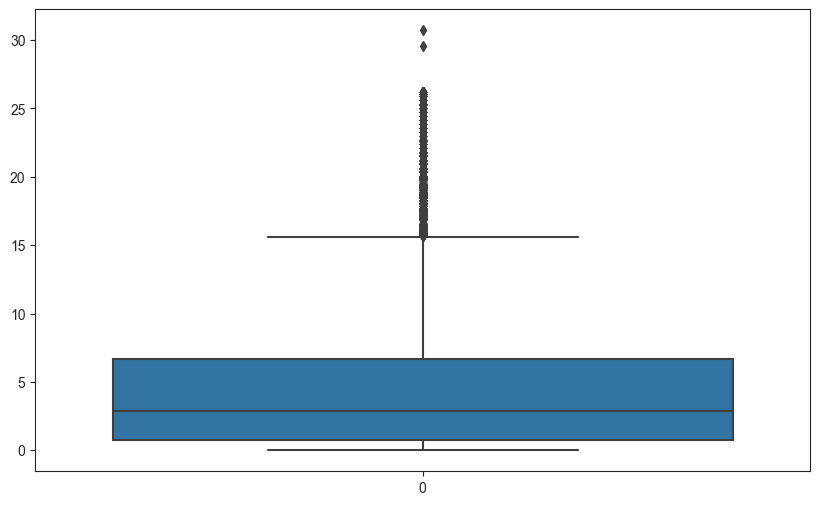

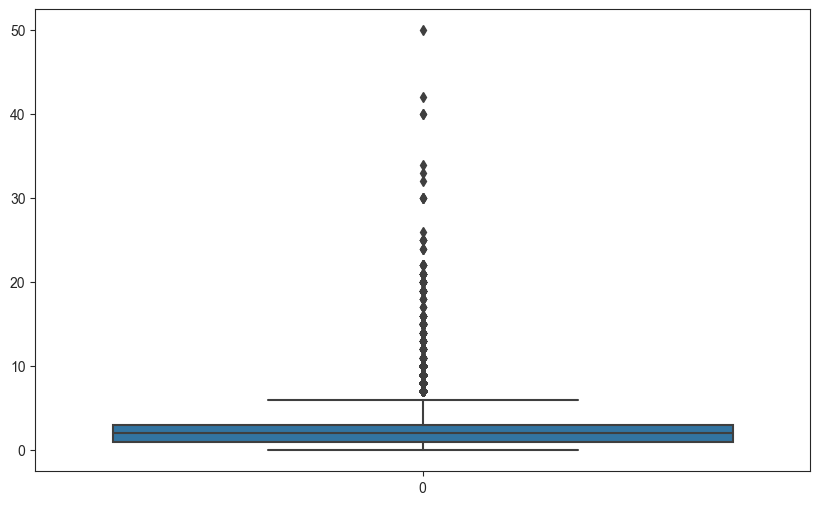

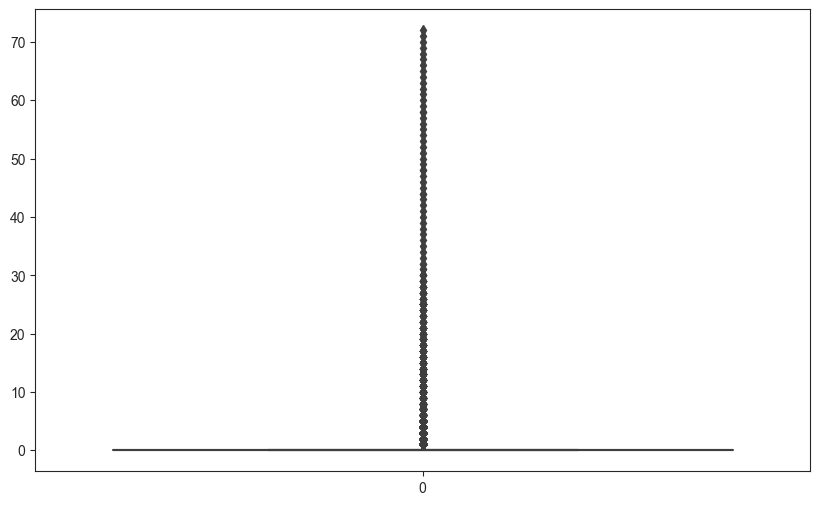

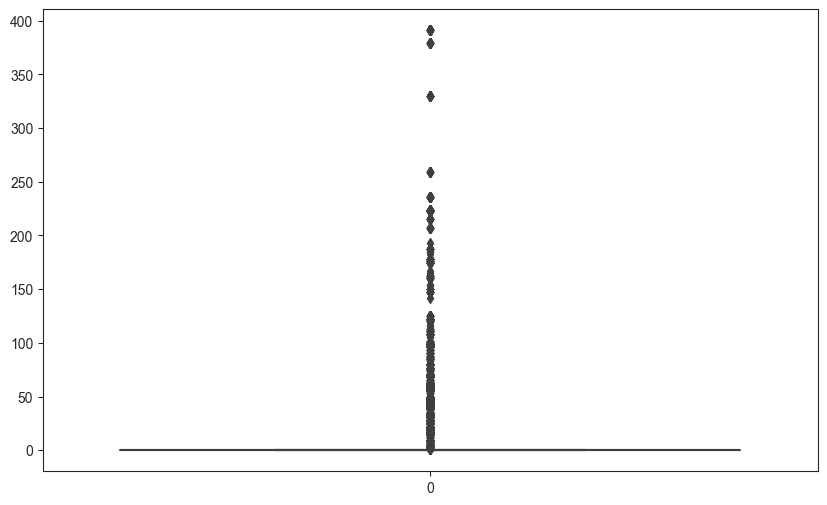

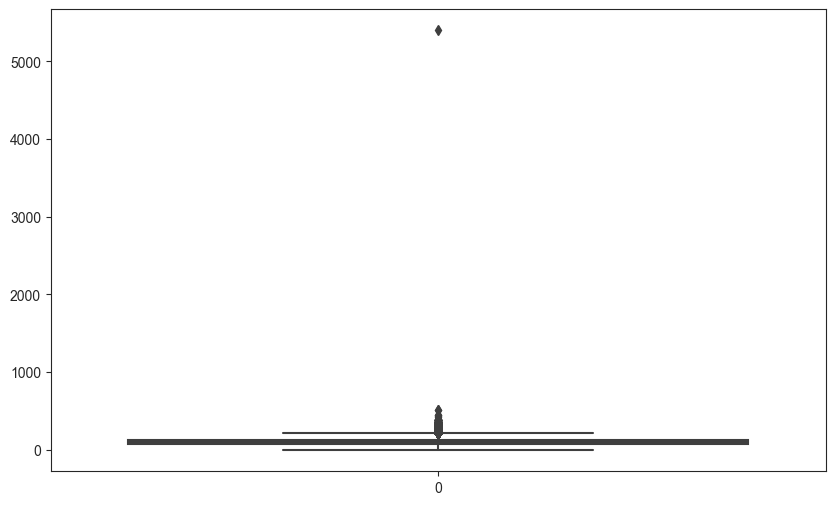

In [15]:
for i in continuous_feature:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

In [16]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df

In [17]:
for col in continuous_feature:
         detect_outliers(col)


 #### lead_time ####
percentile25 0.75
percentile75 6.71
Upper limit 15.649999999999999
Lower limit -8.19

 #### stays_in_week_nights ####
percentile25 1.0
percentile75 3.0
Upper limit 6.0
Lower limit -2.0

 #### previous_bookings_not_canceled ####
percentile25 0.0
percentile75 0.0
Upper limit 0.0
Lower limit 0.0

 #### days_in_waiting_list ####
percentile25 0.0
percentile75 0.0
Upper limit 0.0
Lower limit 0.0

 #### adr ####
percentile25 69.5
percentile75 126.0
Upper limit 210.75
Lower limit -15.25


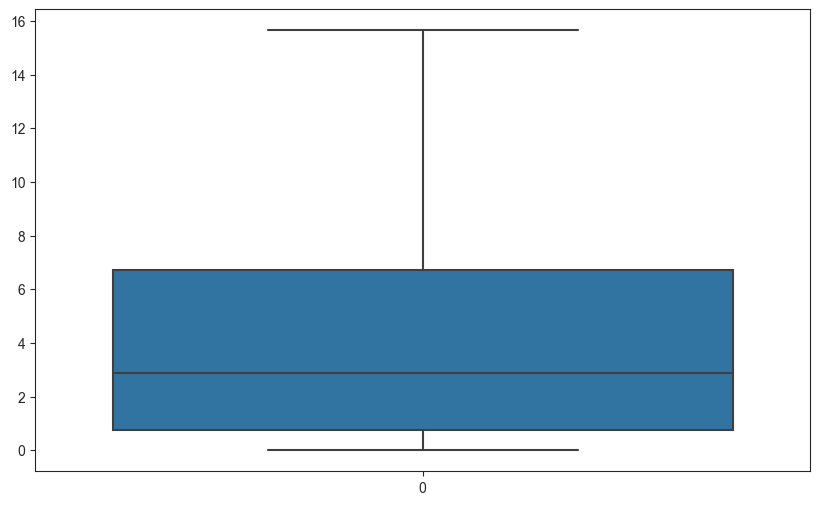

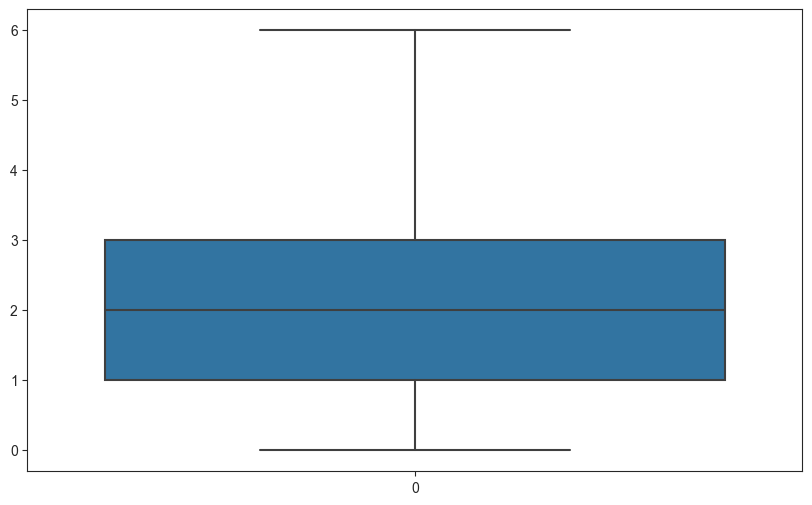

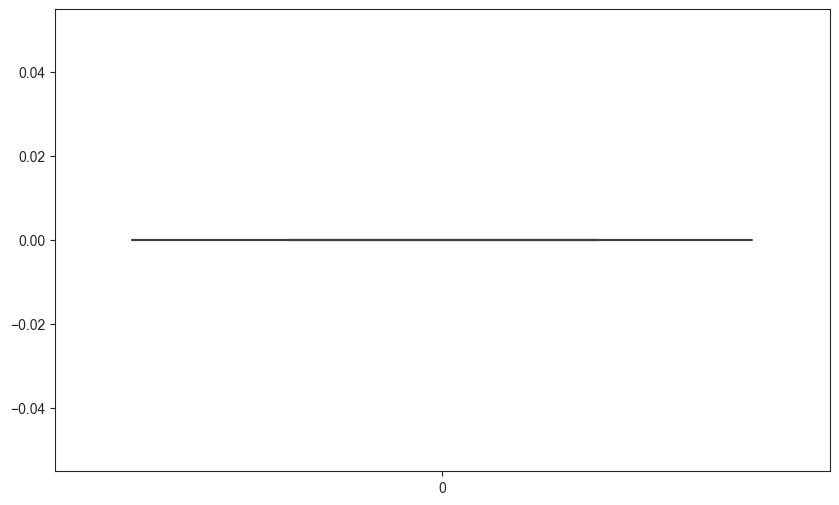

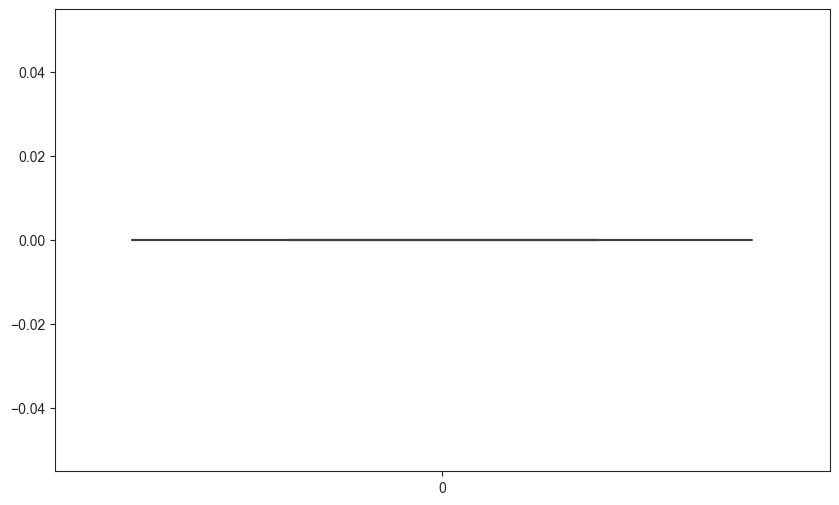

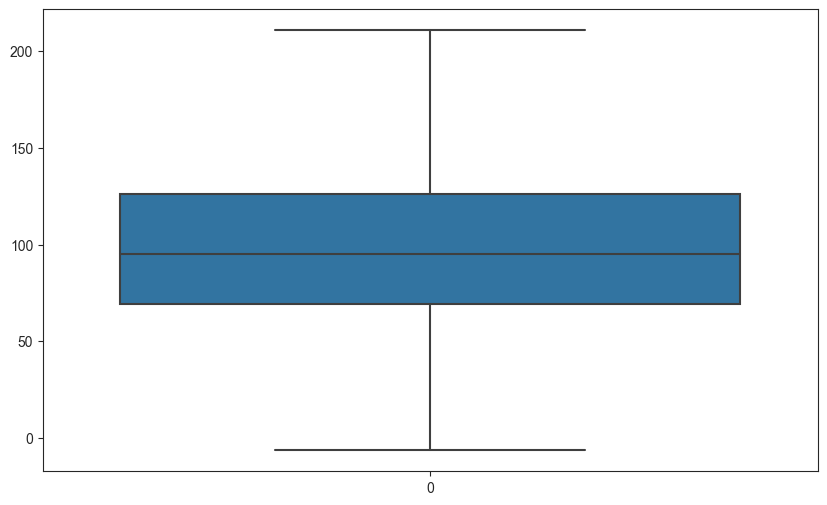

In [18]:
for i in continuous_feature:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

In [19]:
df.drop(['previous_bookings_not_canceled', 'days_in_waiting_list'], inplace=True, axis=1)

* **Check Distribution of Lead Time column**

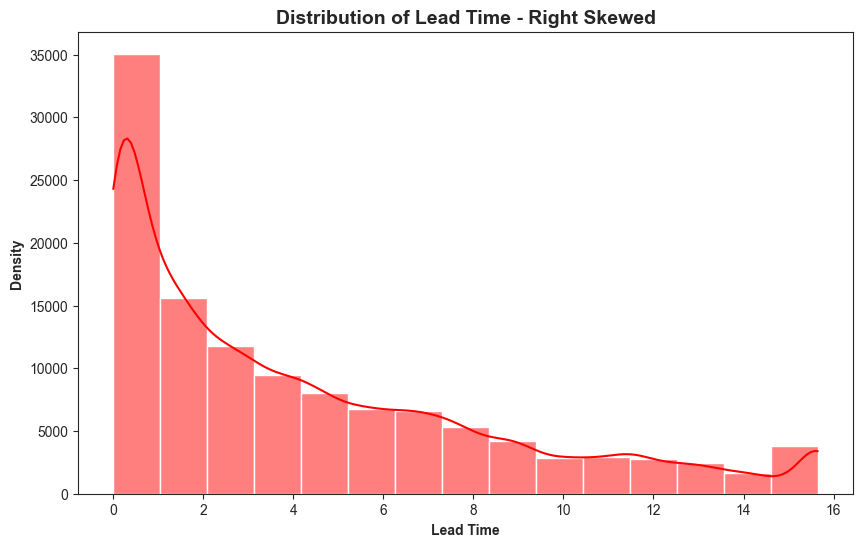

In [20]:
plt.figure(figsize=(10,6))
sns.set_style('ticks')
ax = sns.histplot(df['lead_time'],bins = 15,color = 'r',kde = True)
ax.set_title('Distribution of Lead Time - Right Skewed',fontsize = 14, weight='bold')
ax.set_xlabel("Lead Time",weight = 'bold')
ax.set_ylabel("Density",weight = 'bold');

In [21]:
df[['lead_time']] = df[['lead_time']].apply(np.log1p)

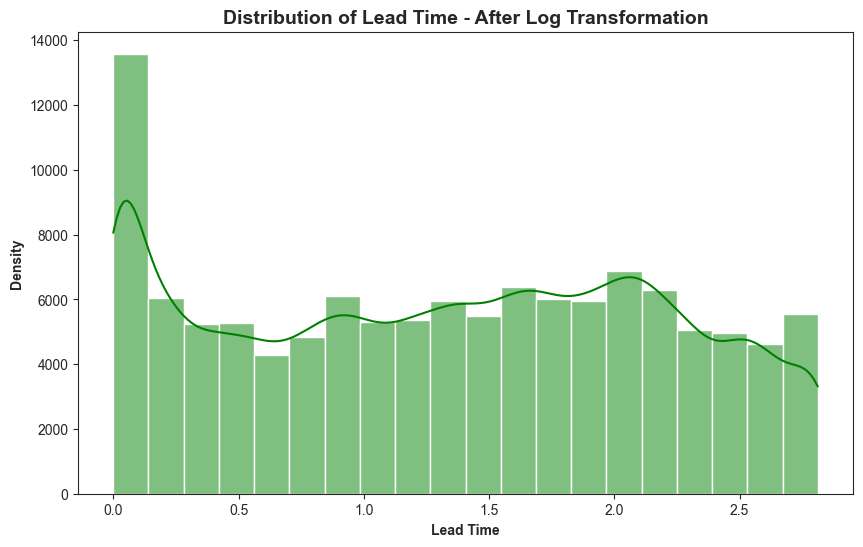

In [22]:
plt.figure(figsize=(10,6))
sns.set_style('ticks')
ax = sns.histplot(df['lead_time'],bins = 20,color = 'g', kde= True)
ax.set_title('Distribution of Lead Time - After Log Transformation',fontsize = 14, weight='bold')
ax.set_xlabel("Lead Time",weight = 'bold')
ax.set_ylabel("Density",weight = 'bold');

In [23]:
df.dropna(inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119205 entries, 0 to 119209
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   hotel                      119205 non-null  int64  
 1   is_canceled                119205 non-null  int64  
 2   lead_time                  119205 non-null  float64
 3   arrival_date_year          119205 non-null  int64  
 4   arrival_date_month         119205 non-null  int64  
 5   arrival_date_day_of_month  119205 non-null  int64  
 6   stays_in_weekend_nights    119205 non-null  int64  
 7   stays_in_week_nights       119205 non-null  int64  
 8   meal                       119205 non-null  object 
 9   country                    119205 non-null  object 
 10  market_segment             119205 non-null  object 
 11  distribution_channel       119205 non-null  object 
 12  previous_cancellations     119205 non-null  int64  
 13  reserved_room_type         11

In [25]:
cl = df['country'].value_counts()

In [26]:
l = 0
for i in cl:
    if i <= 500:
        l += 1

l

157

In [27]:
df['country'].value_counts().head(20)

PRT    48956
GBR    12120
FRA    10401
ESP     8560
DEU     7285
ITA     3761
IRL     3374
BEL     2342
BRA     2222
NLD     2103
USA     2093
CHE     1726
CN      1279
AUT     1263
SWE     1020
CHN      999
POL      918
ISR      669
RUS      630
NOR      607
Name: country, dtype: int64

In [28]:
(df['country'].nunique() == 1)

False

### DataFrame Split

* **Split Dataframe to X and y**

* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “is_canceled” column.**

In [41]:
!pip install scikit-learn

  Using cached scikit_learn-1.0.2-cp37-cp37m-win_amd64.whl (7.1 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [29]:
from sklearn.model_selection import train_test_split
X = df.drop(['is_canceled'], axis=1)
y = df['is_canceled']

* **Save the list of countries to use it in the app**

In [30]:
import pickle
countries = list(X.country.unique())
with open('countryname.pkl', 'wb') as handle:
    pickle.dump(countries, handle)

* **Check all columns which are in Train data set**

In [31]:
all_columns  = list(X.columns)
print(all_columns) 
len(all_columns)

['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'meal', 'country', 'market_segment', 'distribution_channel', 'previous_cancellations', 'reserved_room_type', 'booking_changes', 'deposit_type', 'customer_type', 'adr', 'total_of_special_requests', 'total_guests']


19

###  Feature Encoding

* **Extracting Categorical features from train set for feature encoding**

In [32]:
cat_features = [feature for feature in X.columns if X[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 6


* **Checking for Unique variables in each column**

In [33]:
for feature in cat_features:
    print(feature,':', X[feature].nunique())

meal : 4
country : 177
market_segment : 7
distribution_channel : 4
deposit_type : 3
customer_type : 4


## Pipeline for DataTransformation

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**

* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.


**Binary Encoder is used for Country which had 170 unique values**
* Binary encoding is a combination of Hash encoding and one-hot encoding. In this encoding scheme, the categorical feature is first converted into numerical using an ordinal encoder. Then the numbers are transformed in the binary number. After that binary value is split into different columns.

* Binary encoding works really well when there are a high number of categories, Like Countries in our case

In [48]:
!pip install category-encoders

     ---------------------------------------- 72.4/72.4 kB 3.9 MB/s eta 0:00:00


In [34]:
# Create Column Transformer with 3 types of transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders.binary import BinaryEncoder
num_features = [feature for feature in X.columns if X[feature].dtype != 'O']
oh_columns = ['meal','market_segment','distribution_channel','deposit_type','customer_type']
bin_columns = ['country']

numeric_transformer = StandardScaler()
bin_transformer = BinaryEncoder()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
         ('binary' ,bin_transformer, bin_columns),
         ("oh", oh_transformer, oh_columns),
          ("num", numeric_transformer, num_features)
    ]
)

In [35]:
# Apply Column Transformer
X = preprocessor.fit_transform(X)

In [36]:
X

array([[ 0.        ,  0.        ,  0.        , ..., -2.26278444,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ..., -2.26278444,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ..., -0.57895841,
        -0.72076524, -1.35098757],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.27796495,
         4.32423173,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0811014 ,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ...,  1.13180885,
         1.80173324,  0.040073  ]])

In [37]:
import pickle
pickle.dump(preprocessor, open('preprocess.pkl', 'wb'))

## Train Test Split

In [38]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=36)
X_train.shape, X_test.shape

((89403, 43), (29802, 43))

## Model Selection

* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

In [57]:
!pip install xgboost

     ------------------------------------- 125.4/125.4 MB 22.6 MB/s eta 0:00:00


In [60]:
!pip install catboost

     --------------------------------------- 73.9/73.9 MB 29.7 MB/s eta 0:00:00
  Using cached plotly-5.10.0-py2.py3-none-any.whl (15.2 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached tenacity-8.1.0-py3-none-any.whl (23 kB)


In [61]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [62]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 0.9955
- F1 score: 0.9955
- Precision: 0.9948
- Recall: 0.9929
----------------------------------
Model performance for Test set
- Accuracy: 0.8785
- F1 score: 0.8770
- Precision: 0.8774
- Recall: 0.7864


Naive Bayes
Model performance for Training set
- Accuracy: 0.7771
- F1 score: 0.7582
- Precision: 0.8559
- Recall: 0.4765
----------------------------------
Model performance for Test set
- Accuracy: 0.7731
- F1 score: 0.7534
- Precision: 0.8624
- Recall: 0.4709


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8364
- F1 score: 0.8326
- Precision: 0.8370
- Recall: 0.6916
----------------------------------
Model performance for Test set
- Accuracy: 0.8346
- F1 score: 0.8307
- Precision: 0.8407
- Recall: 0.6905


Logistic Regression
Model performance for Training set
- Accuracy: 0.8028
- F1 score: 0.7964
- Precision: 0.8008
- Recall: 0.6202
----------------------------------
Model performance for Test set
-

### Hyper Parameter Tuning

In [63]:
knn_params = {"n_neighbors": [2, 3, 10, 20, 40, 50]}

rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

cat_params = {"learning_rate": [0.1, 0.01],
              "max_depth": [5, 8, 12, 20, 30]}

In [64]:
randomcv_models = [('KNN', KNeighborsClassifier(), knn_params),
                   ("RF", RandomForestClassifier(), rf_params),
                   ('XGBoost', XGBClassifier(), xgboost_params),
                   ('CatBoost', CatBoostClassifier(verbose=False), cat_params)
                   ]

In [65]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    rf_random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    rf_random.fit(X_train, y_train)
    model_param[name] = rf_random. best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

### Models Re-Trained with Best Parameters

In [36]:
from sklearn.metrics import roc_auc_score,roc_curve
models = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, min_samples_split=2, max_features= 7, max_depth= None),
    "K-Neighbors Classifier": KNeighborsClassifier(n_neighbors=10),
    "XGBClassifier": XGBClassifier(n_estimators= 200, max_depth= 30, learning_rate= 0.1, colsample_bytree= 0.4, n_jobs=-1), 
    "CatBoosting Classifier": CatBoostClassifier(max_depth= 12, learning_rate= 0.1,verbose=False),
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc



    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 0.9955
- F1 score: 0.9955
- Precision: 0.9947
- Recall: 0.9931
- Roc Auc Score: 0.9950
----------------------------------
Model performance for Test set
- Accuracy: 0.8796
- F1 score: 0.8782
- Precision: 0.8761
- Recall: 0.7913
- Roc Auc Score: 0.8620


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.8648
- F1 score: 0.8618
- Precision: 0.8788
- Recall: 0.7350
- Roc Auc Score: 0.8379
----------------------------------
Model performance for Test set
- Accuracy: 0.8354
- F1 score: 0.8317
- Precision: 0.8398
- Recall: 0.6943
- Roc Auc Score: 0.8073


XGBClassifier
Model performance for Training set
- Accuracy: 0.9954
- F1 score: 0.9954
- Precision: 0.9946
- Recall: 0.9929
- Roc Auc Score: 0.9949
----------------------------------
Model performance for Test set
- Accuracy: 0.8786
- F1 score: 0.8772
- Precision: 0.8759
- Recall: 0.7886
- Roc Auc Score: 0.8607


CatBoosting Classifier
Model performance for T

### Plot ROC-AUC curve

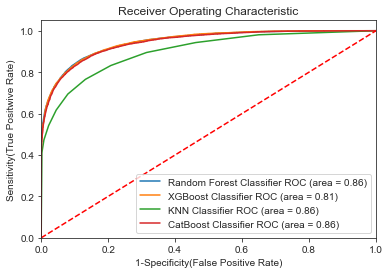

In [44]:
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(n_estimators=1000, min_samples_split=2, max_features= 'auto', max_depth= None),
    'auc': 0.8618
},
{
    'label': 'XGBoost Classifier',
    'model': XGBClassifier(n_estimators= 200, max_depth= 20, learning_rate= 0.1, colsample_bytree= 0.8, n_jobs=-1),
    'auc': 0.8073
},
{
    'label': 'KNN Classifier',
    'model': KNeighborsClassifier(n_neighbors=10),
    'auc': 0.8629 
},
{
    'label': 'CatBoost Classifier',
    'model': CatBoostClassifier(max_depth= 12, learning_rate= 0.1,verbose=False),
    'auc': 0.8615
},
    
]

# Below for loop iterates through your models list
for m in auc_models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], m['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positwive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(r"./images/roc_auc/auc.png")
plt.show()   # Display

### Feature Selection for Model Deployment

In [37]:
best_xgb = XGBClassifier(n_estimators= 200, max_depth= 30, learning_rate= 0.1, colsample_bytree= 0.4, n_jobs=-1)
best_xgb = best_xgb.fit(X_train,y_train)
xgb_pred = best_xgb.predict(X_test)
score = accuracy_score(y_test,xgb_pred)
cr = classification_report(y_test,xgb_pred)

print("FINAL XGB")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL XGB
Accuracy Score value: 0.8786
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     18609
           1       0.88      0.79      0.83     11193

    accuracy                           0.88     29802
   macro avg       0.88      0.86      0.87     29802
weighted avg       0.88      0.88      0.88     29802



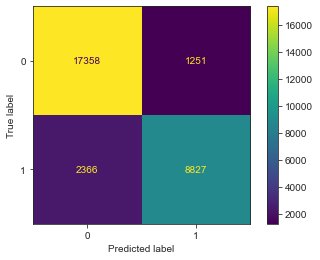

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)

In [39]:
import pickle
 
# Save the trained model as a pickle file.
pickle.dump(best_xgb, open('classificationmodel.pkl', 'wb'))

## ANN

In [39]:
X_train.shape, y_train.shape

((89403, 43), (89403,))

In [40]:
y_train.value_counts()

0    56401
1    33002
Name: is_canceled, dtype: int64

In [68]:
!pip install tensorflow==2.9.0

     -------------------------------------- 444.0/444.0 MB 7.0 MB/s eta 0:00:00
  Using cached wrapt-1.14.1-cp37-cp37m-win_amd64.whl (35 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached grpcio-1.49.1-cp37-cp37m-win_amd64.whl (3.6 MB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ------------------------------------- 525.0/525.0 kB 16.6 MB/s eta 0:00:00
  Using cached libclang-14.0.6-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached termcolor-2.0.1-py3-none-any.whl (5.4 kB)
  Using cached h5py-3.7.0-cp37-cp37m-win_amd64.whl (2.6 MB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp37-cp37m-win_amd64.whl (1.5 MB)
     ---------

In [41]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.Input(43),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2200      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights= True
)

In [44]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)


BATCH_SIZE = 100
EPOCHS = 10

In [45]:

history = model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks = early_stopping
)

Epoch 1/10
716/716 [==============================] - 3s 3ms/step - loss: 0.4073 - auc: 0.8755 - val_loss: 0.3681 - val_auc: 0.9035
Epoch 2/10
716/716 [==============================] - 2s 3ms/step - loss: 0.3539 - auc: 0.9074 - val_loss: 0.3479 - val_auc: 0.9124
Epoch 3/10
716/716 [==============================] - 2s 2ms/step - loss: 0.3420 - auc: 0.9142 - val_loss: 0.3401 - val_auc: 0.9162
Epoch 4/10
716/716 [==============================] - 2s 3ms/step - loss: 0.3343 - auc: 0.9182 - val_loss: 0.3363 - val_auc: 0.9190
Epoch 5/10
716/716 [==============================] - 2s 3ms/step - loss: 0.3291 - auc: 0.9209 - val_loss: 0.3298 - val_auc: 0.9216
Epoch 6/10
716/716 [==============================] - 2s 2ms/step - loss: 0.3253 - auc: 0.9230 - val_loss: 0.3272 - val_auc: 0.9232
Epoch 7/10
716/716 [==============================] - 2s 2ms/step - loss: 0.3219 - auc: 0.9247 - val_loss: 0.3257 - val_auc: 0.9245
Epoch 8/10
716/716 [==============================] - 2s 2ms/step - loss: 0.

In [46]:
history.history.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])

In [47]:
model.evaluate(X_test, y_test)

932/932 [==============================] - 1s 1ms/step - loss: 0.3259 - auc: 0.9239


[0.3258987069129944, 0.9239439368247986]

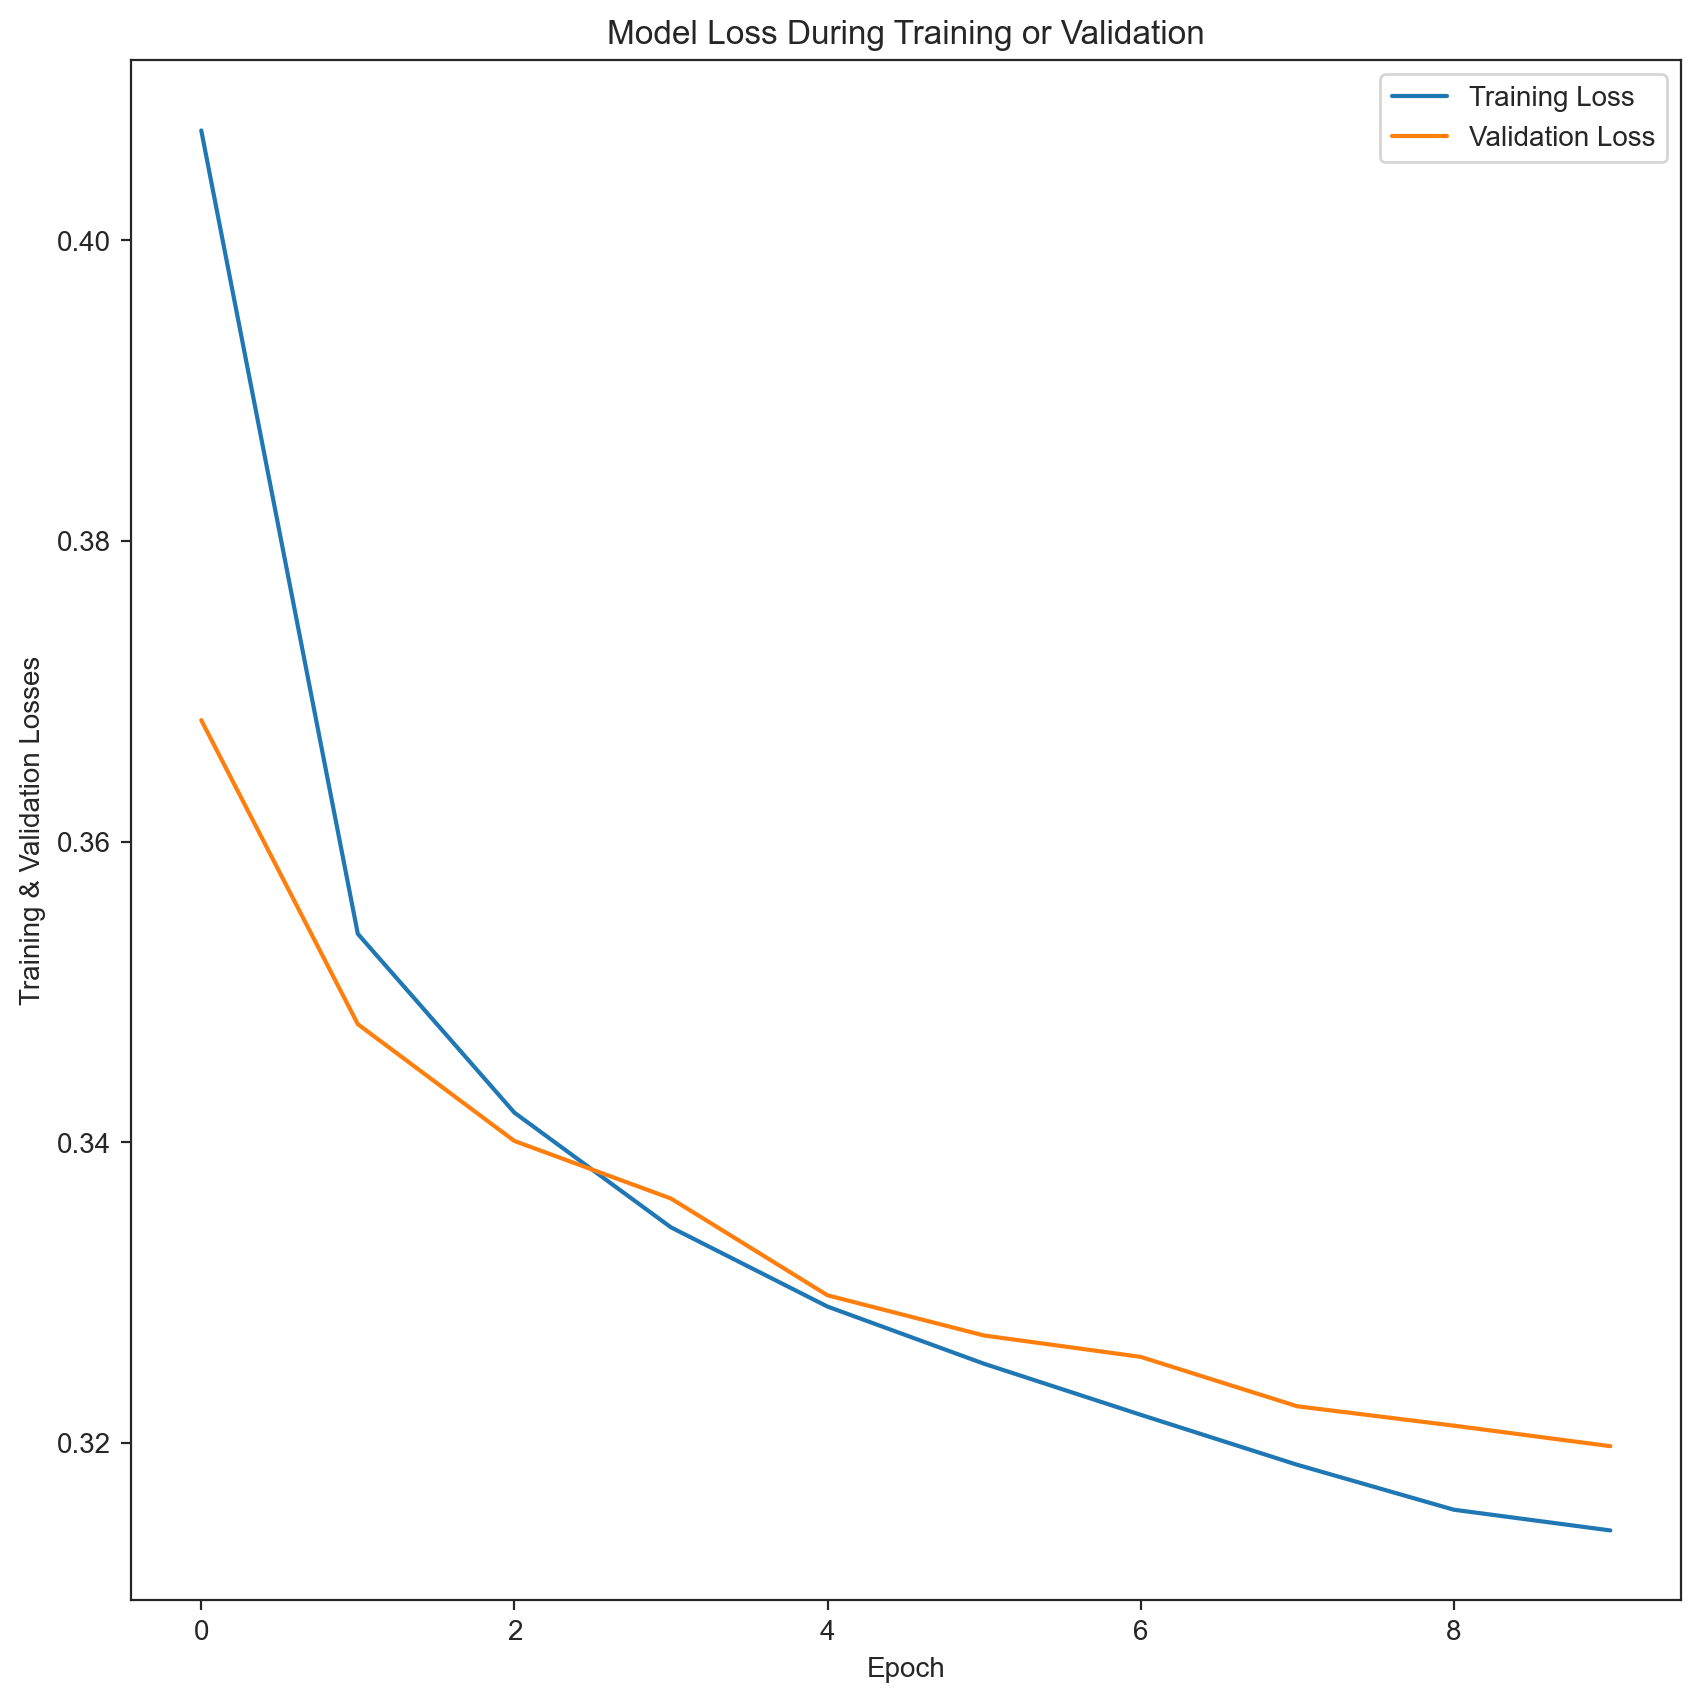

In [49]:
plt.figure(figsize=(10,10),dpi=200)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.title('Model Loss During Training or Validation')
plt.ylabel('Training & Validation Losses')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'])

## Pytorch NN

### Turn data into tensors and create train and test splits
We've investigated the input and output shapes of our data, now let's prepare it for being used with PyTorch and for modelling.

Specifically, we'll need to:

- Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).

- Split our data into training and test sets (we'll train a model on the training set to learn the patterns between X and y and then evaluate those learned patterns on the test dataset).

In [57]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)

TypeError: expected np.ndarray (got Series)

In [58]:
y = np.array(y)

In [59]:
y = torch.from_numpy(y).type(torch.float)

In [60]:
# View the first five samples
X[:5], y[:5]

(tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000, -1.4060,  1.6473,
          -1.6348,  0.1450, -1.6854, -0.9316, -1.5751, -0.1032,  0.5964,  4.3557,
          -2.2628, -0.7208,  0.0401],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000, -1.4060,  1.7506,
          -1.6348,  0.1450, -1.6854, -0.9316, -1.5751, -0.1032,  0.5964,  5.9219,
          -2.2628, -0.7208,  0.0401],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           1.0000,  0.

Now our data is in tensor format, let's split it into training and test sets.

To do so, let's use the helpful function train_test_split() from Scikit-Learn.

We'll use test_size=0.2 (80% training, 20% testing) and because the split happens randomly across the data, let's use random_state=42 so the split is reproducible

In [61]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(95364, 23841, 95364, 23841)

Nice! Looks like we've now got 95364 training samples and 23841 testing samples.

### Building a model
We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

- Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
- Constructing a model by subclassing nn.Module.
- Defining a loss function and optimizer.
- Creating a training loop (this'll be in the next section).

The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and torch.nn as well as setting up device agnostic code.

In [62]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [67]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=43, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=43, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [68]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [70]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [71]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72289, Accuracy: 37.66% | Test loss: 0.71292, Test acc: 39.40%
Epoch: 100 | Loss: 0.45473, Accuracy: 79.76% | Test loss: 0.45265, Test acc: 79.61%
Epoch: 200 | Loss: 0.42739, Accuracy: 80.23% | Test loss: 0.42533, Test acc: 80.32%
Epoch: 300 | Loss: 0.42348, Accuracy: 80.13% | Test loss: 0.42111, Test acc: 80.28%
Epoch: 400 | Loss: 0.42163, Accuracy: 80.18% | Test loss: 0.41915, Test acc: 80.30%
Epoch: 500 | Loss: 0.42052, Accuracy: 80.14% | Test loss: 0.41802, Test acc: 80.32%
Epoch: 600 | Loss: 0.41981, Accuracy: 80.20% | Test loss: 0.41730, Test acc: 80.37%
Epoch: 700 | Loss: 0.41933, Accuracy: 80.20% | Test loss: 0.41681, Test acc: 80.37%
Epoch: 800 | Loss: 0.41900, Accuracy: 80.21% | Test loss: 0.41648, Test acc: 80.36%
Epoch: 900 | Loss: 0.41876, Accuracy: 80.29% | Test loss: 0.41623, Test acc: 80.40%


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10201x2 and 43x10)

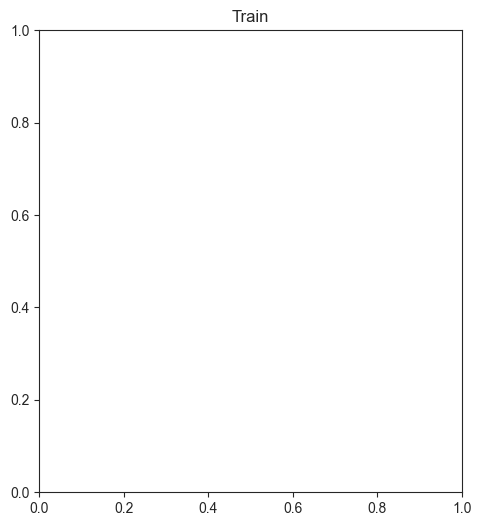

In [83]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [73]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models

In [54]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden1 = nn.Sequential(
            nn.Linear(43, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        ) 
        self.hidden2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.output = nn.Sequential(
            nn.Linear(256, 1)
        )
                
    def forward(self, x):
#         print(x.size(), x.view(x.size(0), -1).size())
        x = x.view(x.size(0), -1)
        x = self.hidden1(x)
        x = self.hidden2(x)
        return F.sigmoid(self.output(x), dim=1)


model = Net()

In [55]:
model

Net(
  (hidden1): Sequential(
    (0): Linear(in_features=43, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
  )
  (output): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [40]:
import torch

import torch.nn.functional as F


# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         # 1 input image channel, 6 output channels, 5x5 square convolution
#         # kernel
# #         self.conv1 = nn.Conv2d(1, 6, 5)
# #         self.conv2 = nn.Conv2d(6, 16, 5)
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(43, 120)  # 5*5 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         # Max pooling over a (2, 2) window
# #         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square, you can specify with a single number
# #         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()
# print(net)

class MNISTDigitsNet(nn.Module):
    def __init__(self):
        super(MNISTDigitsNet, self).__init__()
        
        self.hidden1 = nn.Sequential(
            nn.Linear(43, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        ) 
        self.hidden2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.output = nn.Sequential(
            nn.Linear(256, 1)
        )
                
    def forward(self, x):
#         print(x.size(), x.view(x.size(0), -1).size())
        x = x.view(x.size(0), -1)
        x = self.hidden1(x)
        x = self.hidden2(x)
        return F.sigmoid(self.output(x), dim=1)


model = MNISTDigitsNet()


In [41]:
model

MNISTDigitsNet(
  (hidden1): Sequential(
    (0): Linear(in_features=43, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
  )
  (output): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [42]:
LEARNING_RATE = 3e-4  # Karpathy constant

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [43]:
class EarlyStopping():
    def __init__(self, tolerance=10, min_delta=1e-4):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.min_loss = None
        self.counter = 0
        self.early_stop_flag = False

    def __call__(self, validation_loss):
        if self.min_loss is None:
            self.min_loss = validation_loss
    
        delta = validation_loss - self.min_loss
        
        if (delta > 0) and (abs(delta) > self.min_delta):
            self.counter += 1
            if self.counter >= self.tolerance:  
                self.early_stop_flag = True
        else:
            self.counter = 0
            self.min_loss = validation_loss

        return self.early_stop_flag

In [44]:
def train_epoch(model, dataloader, f_loss, optimizer, cuda):
    total_loss = 0.0
    total_accuracy = 0.0
    
    model.train()
    for images, labels in dataloader:
        if cuda:
            images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        
        output = model(images)
        loss = f_loss(output, labels)
        
        loss.backward()
        optimizer.step()
        
        _, top_pred = output.max(dim=1)  # output.topk(1, dim=1)
        is_equals = (top_pred == labels.view(*top_pred.shape))
        
        total_loss += loss.item()
        total_accuracy += torch.mean(is_equals.type(torch.FloatTensor))
        
    return total_loss / len(dataloader), total_accuracy / len(dataloader)

In [45]:
def validate_epoch(model, dataloader, f_loss, cuda):
    total_loss = 0.0
    total_accuracy = 0.0

    with torch.no_grad():
        model.eval()
        for images, labels in valid_loader:
            if cuda:
                images, labels = images.cuda(), labels.cuda()

            output = model(images)
            
            _, top_pred = output.max(dim=1)  # output.topk(1, dim=1)
            is_equals = (top_pred == labels.view(*top_pred.shape))

            total_loss += f_loss(output, labels).item()
            total_accuracy += torch.mean(is_equals.type(torch.FloatTensor))
        
    return total_loss / len(dataloader), total_accuracy / len(dataloader)

In [46]:
EPOCHS = 100

early_stopping = EarlyStopping()

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for e in range(EPOCHS):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, cuda)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    valid_loss, valid_accuracy = validate_epoch(model, valid_loader, criterion, cuda)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    if (e == 0) or ((e + 1) % 5 == 0):
        print(
            f"Epoch: [{e + 1}/{EPOCHS}]\t",
            f"Training Loss: {train_loss:.4f}\t",
            f"Train Accuracy: {train_accuracy:.4f}\t"
            f"Validation Loss: {valid_loss:.4f}\t",
            f"Validation Accuracy: {valid_accuracy:.4f}"
        )
    
    if early_stopping(valid_loss):
        print(f"[EARLY STOPPING] epoch: {e}, saving model...")
        torch.save(model.state_dict(), "model.pt")
        break
else:
    print("Saving model...")
    torch.save(model.state_dict(), "model.pt")

NameError: name 'train_loader' is not defined